# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
#import necessary packages 
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import matplotlib.image as mpimg
#from sklearn.model_selection import train_test_split
import cv2
import os
import csv

from os import listdir

%matplotlib inline


In [2]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = "Data/train.p"
testing_file =  "Data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Setting training and test set here.

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes next

import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import cv2

---
### Normalization process 

Label: 38


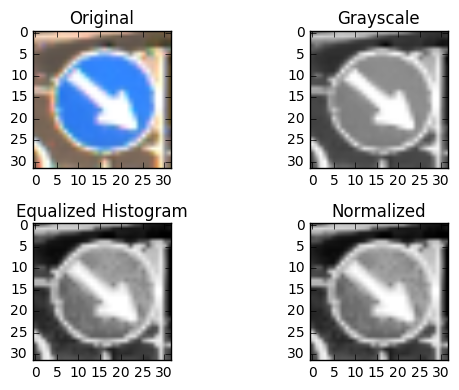

In [5]:
###Lets do shuffling and visualize image with our normalization process 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

im = 0
# Copy the image
orig = np.copy(X_train[0,...])
print('Label: %d' % (y_train[im]))

# Convert to grayscale
grayscale = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# Equalize the histogram
eq_gray_hist = cv2.equalizeHist(grayscale)

# Normalize the values
norm_gray = eq_gray_hist/255. - 0.5

# Plot the results
fig = plt.figure()

#show the original plot
grid = plt.subplot(2,2,1)
grid.set_title('Original')
grid.imshow(orig)

#show the grayscale picture
grid = plt.subplot(2,2,2)
grid.set_title('Grayscale')
grid.imshow(grayscale, cmap='gray')

#show the equalized histogram picture
grid = plt.subplot(2,2,3)
grid.set_title('Equalized Histogram')
grid.imshow(eq_gray_hist, cmap='gray')

#show the normalized picture
grid = plt.subplot(2,2,4)
grid.set_title('Normalized')
grid.imshow(norm_gray, cmap='gray')

plt.tight_layout()
plt.show()

------- 
Highest count: 2250.0 (class 2)
Lowest count: 210.0 (class 0)
------- 


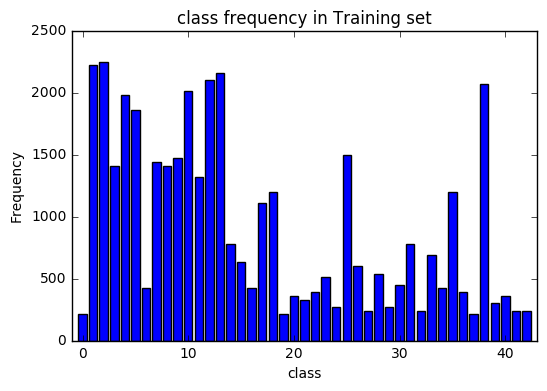

In [6]:
# Create a barchart of frequencies
# Display highest count and lowest count of classes

assert (n_classes == len( np.unique(y_train) )), '1 or more class(es) not represented in training set'
        
def class_freq_hig_low_count(y, verbose=False):
    num_classes = len(np.unique(y))
    n_imgs_per_class = np.zeros( num_classes )

    for this_class in range( num_classes ):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum( y  == this_class )) )
        n_imgs_per_class[this_class] = np.sum(y == this_class )
    
    return n_imgs_per_class


class_freq = class_freq_hig_low_count(y_train)
print('------- ')
print('Highest count: {} (class {})'.format(np.max(class_freq), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(np.min(class_freq), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(n_classes), class_freq , align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.title("class frequency in Training set")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Converting images to gray scale reduces the total size of the dataset by 66% by going from 3 color channels to just 1. This will improve the speed of the algorithm without sacrificing much information. The main features of a traffic sign are present in the shapes of the signs. OpenCV provides helper functions to make these transformations with just a few lines of code.

Using the normalization method outlined above, we create the function pre_process_gray to generalize the method to multiple images.

In [7]:
### Preprocess the data here.
### Doing here pre processing ,converting the image to greyscale 
def pre_process_gray(images):
    # Convert images to grayscale histogram equalize,
    tmp = []
    for i in range(images.shape[0]):
        gray = cv2.cvtColor(images[i,...], cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        norm_grey = gray/255. - 0.5
        tmp.append(norm_grey)
        
    tmp = np.array(tmp)
    return tmp[...,np.newaxis]

def one_hot(array):
    if array.ndim > 1: return array
    return np.array([[1 if j == array[i] else 0 for j in range(n_classes)] \
                     for i in range(len(array))])

def de_one_hot(array):
    if array.ndim == 1: return array
    return np.array([i.argmax() for i in array])

def center_normalization(X_train):
    x_train = X_train.astype(np.float32)
    x_train -= np.mean(x_train, axis=0)
    x_train /= np.std(x_train, axis=0)

    return x_train

In [8]:
print("Original Data Dimensions:\nData: %r | Labels: %r\n" % (X_train.shape, y_train.shape))

X_train = pre_process_gray(X_train)
#X_train = center_normalization(X_train)
print("Pre-Processed Data Dimensions:\nData: %r | Labels: %r\n" % (X_train.shape, y_train.shape))

Original Data Dimensions:
Data: (39209, 32, 32, 3) | Labels: (39209,)

Pre-Processed Data Dimensions:
Data: (39209, 32, 32, 1) | Labels: (39209,)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

1) The first step I took to pre-process the images was to convert them to grayscale.

2) I chose to convert them to grayscale by a process of elimination.

3) Converting images to gray scale reduces the total size of the dataset by 66% by going from 3 color channels to just 1. 

4) This will improve the speed of the algorithm without sacrificing much information. 

5) The main features of a traffic sign are present in the shapes of the signs. OpenCV provides helper functions to make these transformations with just a few lines of code.

6) The method I chose to use was equalizing the histogram of the image, as it was easy to implement with cv2.

7) I normalized the pixel range to between [-0.5, 0.5] to create a well-conditioned problem for the optimizer to converge to a solution.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer**

**Data Augmentation**

Now that our images are transformed and normalized, we need to expand the dataset to give the model a better chance of converging to a solution.

I did look into differnet papers that had the same topic , the way they addressed creating additional data from given data set. Affine transform is one approach of them. 


Affine transformations are any linear transformation of a matrix which maintains the parrallelism of the lines in the image. When viewing an object from a fixed viewpoint, we can simulate the view of the same object from a different viewpoint by using affine transformations.
Examples of such transformations include rotation, translation, and shear.

Using the below function, we will create randomized transformations of our training images to simulate viewing the traffic signs from different angles, with the hope that this will make our model more robust in classification of new images.

This is one such paper that i came across, that explained me mathematically about affine transform http://merganser.math.gvsu.edu/david/reed03/notes/chap4.pdf 

But the model idea for this transformation is taken from vivek yadhav's implementation. 

I  referred to opencv tutorial 
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
regarding the usage of affine transform to get a better understanding on this. 

In [9]:
### Generate data additional data (OPTIONAL!)

def transformation_fun(image, angle, shear, translation):
    ang_rot = np.random.uniform(angle) - angle/2
    rows, cols, color_channels = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

    trans_x = translation*np.random.uniform() - translation/2
    trans_y = translation*np.random.uniform() - translation/2
    translation_matrix = np.array([[1, 0, trans_x],[0, 1, trans_y]]).astype('float32')
    
    pts1 = np.array([[5,5],[20,5],[5,20]]).astype('float32')
    
    pt1 = 5 + shear*np.random.uniform()- shear/2
    pt2 = 20 + shear*np.random.uniform()- shear/2
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_matrix = cv2.getAffineTransform(pts1, pts2)
        
    image = cv2.warpAffine(image, rotation_matrix, (cols,rows))
    image = cv2.warpAffine(image, translation_matrix,(cols,rows))
    image = cv2.warpAffine(image, shear_matrix, (cols,rows))
    
    return image

Looking to see if the image is transfored in a right way So testing an Image

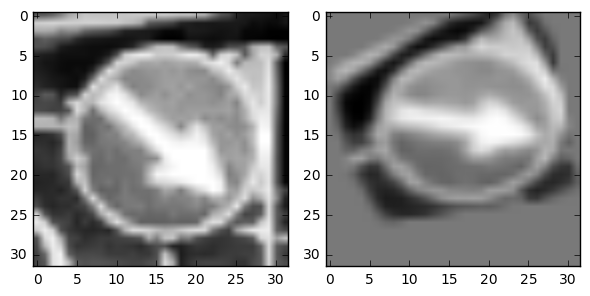

In [10]:
im = 0

out_transformed_image = transformation_fun(X_train[im,...], 20, 10, 5)
stacked = np.dstack((X_train[im,...], out_transformed_image))

grid = plt.subplot(1,2,1)
plt.imshow(stacked[...,0], cmap='gray')

grid = plt.subplot(1,2,2)
plt.imshow(out_transformed_image, cmap='gray')

plt.tight_layout()

Now we need to scaling factors to increase the images count, 
we already have the images frequency calculated above under class_freq_hig_low_count 

the logic follwed is as below :

for  <500 observations, increase count by 8x

for  <1000 observations, increase count by 4x

Else, for any other class increase count by 2x

Initially i tried to expand the image set by 10x, 5x, 2x. But that was causing more non uniformity in the training and validation set. So i had to change the values to 8x, 4x, 2x to get some uniformity in the distribution. 

In [11]:
segregated_data = []
class_obs = []

for class_ in range(n_classes):
    segregated_class = X_train[y_train == class_,...]
    segregated_data.append(segregated_class)
    class_obs.append(segregated_class.shape[0])

In [12]:
def expand_class(images, n_obs):
    transformed_images = []
    
    if n_obs < 500: factor = 8
    elif n_obs < 1000: factor = 4
    else: factor = 2
    
    for image in images:
        for _ in range(factor-1):
            transformed_images.append(transformation_fun(image, 20, 10, 5))
    
    transformed_images = np.array(transformed_images)
    transformed_images = transformed_images[...,np.newaxis]
    expanded_class = np.concatenate((images, transformed_images), axis=0)
    return (expanded_class, expanded_class.shape[0])

In [13]:
expanded_data = None
expanded_labels = None

for class_, images in enumerate(segregated_data):
    if expanded_data is None:
        expanded_data, obs = expand_class(images, class_obs[class_])
        expanded_labels = np.full(obs, class_, dtype='int64')
    else:
        tmp, obs = expand_class(images, class_obs[class_])
        expanded_data = np.concatenate((expanded_data, tmp), axis=0)
        expanded_labels = np.concatenate((expanded_labels, np.full(obs, class_, dtype='int64')), axis=0)

del segregated_data, class_obs
print("Expanded Data Dims:\nData: %r | Labels: %r\n" % (expanded_data.shape, expanded_labels.shape))

Expanded Data Dims:
Data: (123296, 32, 32, 1) | Labels: (123296,)



------- 
Highest count: 4500.0 (class 2)
Lowest count: 1680.0 (class 0)
------- 


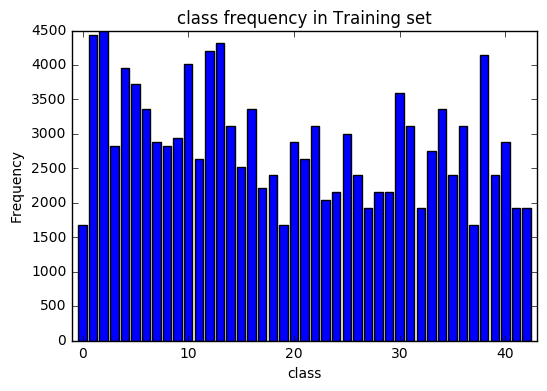

In [14]:

class_freq = class_freq_hig_low_count(expanded_labels)
print('------- ')
print('Highest count: {} (class {})'.format(np.max(class_freq), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(np.min(class_freq), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(n_classes), class_freq , align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.title("class frequency in Training set")
plt.show()

We see that our transform works fine. we need to prepare helper functions for expanding the data 

Now that the data set expansion is done , we need to split this data into training and validation sets.next step is to divide the data into training set and validation set. For this i will have to create a function for data division , keeping 80% for training and 20 % for validation. 

In [15]:
def train_valid_set_split(data, labels, train_percent):
    n_obs = data.shape[0]
    assert n_obs == labels.shape[0], "Different number of images and labels"
    
    data, labels = shuffle(data, labels)
    
    cutoff = np.round(train_percent * n_obs).astype('int64')
    
    train = (data[:cutoff,...], labels[:cutoff])
    val = (data[cutoff:,...], labels[cutoff:])
    
    assert train[0].shape[0] + val[0].shape[0] == n_obs, "Some thing went wrong with training and val data"
    return (train, val)

In [16]:
train_percent = 0.8

expanded_labels = one_hot(expanded_labels)
train, val = train_valid_set_split(expanded_data, expanded_labels, train_percent)

X_test, y_test = pre_process_gray(X_test), one_hot(y_test)
test = (X_test, y_test)

print("Train Size: %d | Val Size: %d | Test Size: %d"
     % (train[0].shape[0], val[0].shape[0], test[0].shape[0]))


Train Size: 98637 | Val Size: 24659 | Test Size: 12630


In [17]:
from utils import ConvNet
import tensorflow as tf

signal_class = ConvNet(batch_size=32, color_channels=1, image_shape=(32,32), 
                         n_classes=43, learning_rate=1e-3)

signal_class.conv2d('L0', kernel_size=1, depth=3, ACTIVATION=tf.nn.elu)

signal_class.conv2d('conv1_1', kernel_size=3, depth=32, input_padding=1, ACTIVATION=tf.nn.elu)
signal_class.conv2d('conv1_2', kernel_size=3, depth=32, input_padding=1, ACTIVATION=tf.nn.elu)
signal_class.pool2d('MAX')

signal_class.conv2d('conv2_1', kernel_size=3, depth=64, input_padding=2, ACTIVATION=tf.nn.elu)
signal_class.conv2d('conv2_2', kernel_size=3, depth=64, input_padding=2, ACTIVATION=tf.nn.elu)
signal_class.pool2d('MAX')

signal_class.conv2d('conv3_1', kernel_size=3, depth=128, input_padding=1, ACTIVATION=tf.nn.elu)
signal_class.conv2d('conv3_2', kernel_size=3, depth=128, input_padding=1, ACTIVATION=tf.nn.elu)
signal_class.pool2d('MAX')

signal_class.fully_connected('FC1', 1024, ACTIVATION=tf.nn.elu)
signal_class.dropout()

signal_class.fully_connected('FC2', 512, ACTIVATION=tf.nn.elu)
signal_class.dropout()

signal_class.fully_connected('FC3', 256, ACTIVATION=tf.nn.elu)
signal_class.dropout()

signal_class.fully_connected('FC4', 256, ACTIVATION=tf.nn.elu)

signal_class.fully_connected('OUT', 43, ACTIVATION=None)

In [18]:
signal_class.train(train, val, max_epochs=100, l2_beta=0.001, threshold=10)

Starting training process:
 Epoch: 001 | 100.0% - Loss: 11.015338496 | Validation Acc: 58.2529% - Best!
 Epoch: 002 | 100.0% - Loss: 2.766594076 | Validation Acc: 73.8201% - Best!
 Epoch: 003 | 100.0% - Loss: 2.408231010 | Validation Acc: 83.7939% - Best!
 Epoch: 004 | 100.0% - Loss: 2.304119942 | Validation Acc: 87.9104% - Best!
 Epoch: 005 | 100.0% - Loss: 2.112903742 | Validation Acc: 89.4212% - Best!
 Epoch: 006 | 100.0% - Loss: 1.972162512 | Validation Acc: 92.9812% - Best!
 Epoch: 007 | 100.0% - Loss: 1.898772983 | Validation Acc: 94.1229% - Best!
 Epoch: 008 | 100.0% - Loss: 1.790625451 | Validation Acc: 95.1605% - Best!
 Epoch: 009 | 100.0% - Loss: 1.743211982 | Validation Acc: 94.8915%
 Epoch: 010 | 100.0% - Loss: 1.706551452 | Validation Acc: 96.2926% - Best!
 Epoch: 011 | 100.0% - Loss: 1.687432965 | Validation Acc: 96.1130%
 Epoch: 012 | 100.0% - Loss: 1.645239007 | Validation Acc: 96.0211%
 Epoch: 013 | 100.0% - Loss: 1.643933963 | Validation Acc: 97.3667% - Best!
 Epoch: 

Normalized confusion matrix
Accuracy: 0.96659


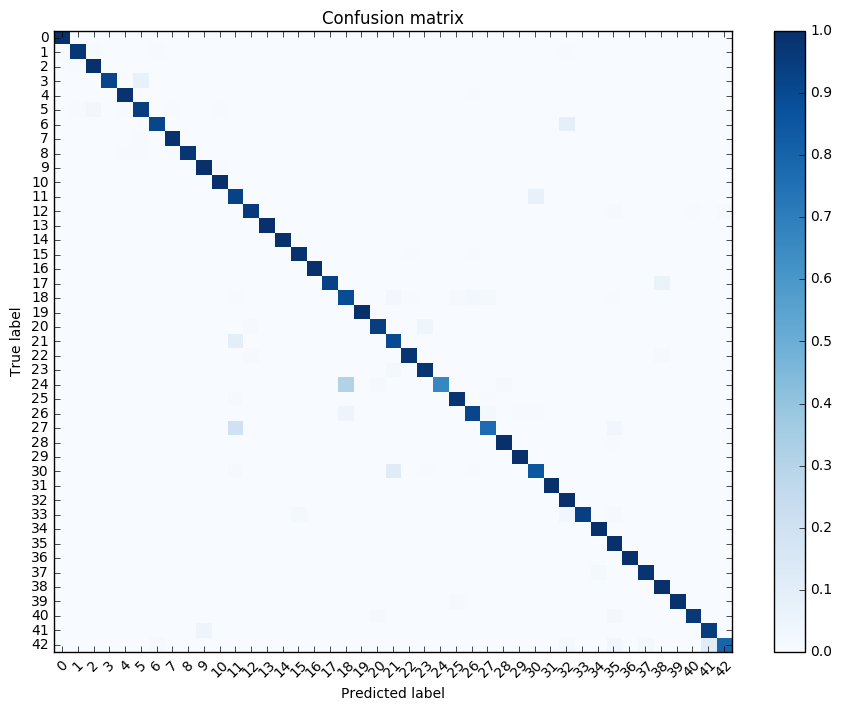

In [19]:
print("Accuracy: %1.5f" % (signal_class.score(test, plot=True, normalize=True)))

### comments about the accuracy and run:
Accuracy is 96.659, its ok!! we see that for some labels still prediction is less. But thats ok




### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
Convolutional Layer: 3x3x32

Convolutional Layer: 3x3x32

Max Pooling Layer: 2x2 Kernel with step size of 2

Convolutional Layer: 3x3x64

Convolutional Layer: 3x3x64

Max Pooling Layer: 2x2 Kernel with step size of 2

Convolutional Layer: 3x3x128

Convolutional Layer: 3x3x128

Max Pooling Layer: 2x2 Kernel with step size of 2

Fully Connected Layer: 1024 Neurons

Dropout Layer: Keep Prob of 0.5

Fully Connected Layer: 512 Neurons

Dropout Layer: Keep Prob of 0.5

Fully Connected Layer: 256 Neurons

Dropout Layer: Keep Prob of 0.5

Fully Connected Layer: 256 Neurons

Output Layer: 43 Neurons



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Optimizer: Adam Optimizer
Learning Rate: 0.001
Batch Size: 64
Beta : 0.001
Max Epochs: 100
threshold: 10

I chose to use the Adam Optimizer because it converges to a solution much faster and more reliably than stochastic gradient descent. The learning rate comes from the default settings for the optimizer. I chose a batch size of 64. 

I chose a max epochs of 100 to ensure that the model would begin to overfit, which ensures that a maximum validation accuracy would be reached. The weights for the model were only saved if the new validation accuracy was higher than the previous best. I did made sure that if there is no improvement in accuracy the model stops training further. this will help in preventing overfitting

Usually it took about 14 epochs before the validation accuracy converged, although more epochs did slightly increase the performance on the validation set. A dropout about 50% reduces overfitting. A beta value of 0.001 further prevents the network to get conditioned badly.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

This project very interesting as it involves most of the concepts that i learned convolutional neural networks, and I learned a lot about the intricacies and implementation of convolutional neural networks in TensorFlow.By the time i started this project i did see some most important and good discussions already in slack. I did follow vivek yadhav and started  Using his techniques as a starting point. 



I did lot of trail and errors, iterating on my ConvNet class to improve it's functionality and provide relevant information on the model performance. initially I wanted set up Vivek's network and trained it to see the results. I took it as a base and modified per my execution results.

I added dropout layers to the fully connected layers in the model. Dropout is very effective at preventing overfitting, as it essentailly creates an ensemble of smaller nets all voting on the correct prediction.Dropout randomly sets weights in a layer to zero during training. 

I chose to use the softmax activation function for my outputs, as this function would allow the model to express it's certainty in it's prediction.  if we use softmax at the output layer it will almost work like Max layer as well as it will be differentiable to train the optimizer. Exponential function will increase the probability of maximum value of the previous layer compare to other value. Also, summation of all output will be equal to 1.0 always.

I chose to use the cross entropy loss function, as this allows the model to train against a multi-class dataset. 
Alternative to sum-squared error for binary outputs; diverges when the network gets an output completely wrong.

From different papers i understood that using cross entropy loss function:

Can produce faster learning for some types of problems.

Can learn some problems where sum-squared error gets stuck in a local minimum, because it heavily penalizes “very wrong” outputs.


My activation function for the convolutional layers were Exponential Linear Units (ELU). Initially i tried doing trail and error using ReLU and as well Leaky ReLU. I see that ELU function is similar to the ReLU activation, except that instead of a linear positive half and a zero negative half. I have read papers that ELU gave better results for CIFAR-100.

ReLU:
f(x)=(x>0)*x
f'(x)=x>0

ELU:
f(x)=(x>=0)*x + (x<0) * alpha * (exp(x)-1)
f'(x)=(x>=0) + (x<0) * (f(x) + alpha)


Main motivation is to speedup learning via avoiding a bias shift which ReLU is predisposed to. I read that ELU networks  become a real time saver in convolutional networks, which are notably time-intensive to train from scratch otherwise.



I added max-pooling layers to help the model become scale and translation invariant. Max-pooling helps to achieve this by only propogating the highest activation in a region, effectively shrinking the seach space for features and increasing the receptive field for higher level features.


In conclusion, this project helped in execrising the concepts of CNN and deep learning using tensor flow. 
https://github.com/Hvass-Labs/TensorFlow-Tutorials tutorials as well helped in doing a lot of trail and error for this project. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

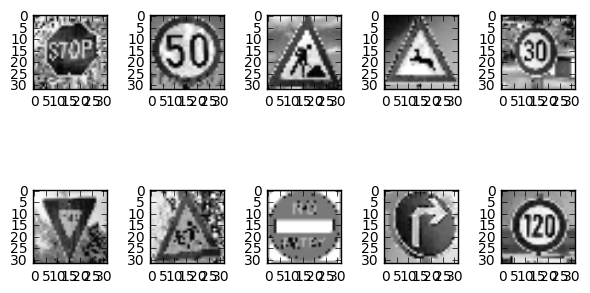

In [40]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.pyplot as plt
import cv2

test_images = []
path = './test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    test_images.append(img)

test_images = np.array(test_images)
test_images = pre_process_gray(test_images)


fig = plt.figure()

for i, image in enumerate(test_images):
    grid = plt.subplot(2,5,i+1)
    grid.imshow(image[...,0], cmap='gray')

plt.tight_layout()
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I did add 9 images of traffic signals taken from web to test the accuracy.Below is the prediction analysis and the accuracy rate for the above 9.

In [49]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
### Run the predictions here.
### Feel free to use as many code cells as needed.

import pandas as pd

labels = np.array([ 14, 2,25, 31, 1,13,28,17, 33,8])
pred = de_one_hot(signal_class.predict(test_images))

df = pd.DataFrame(data=np.array((labels, pred)).T, columns=['Labels', 'Predictions'])
acc = signal_class.score((test_images, one_hot(labels)))

print('Accuracy: %1.5f\n\n' % (acc), df)


Accuracy: 0.90000

    Labels  Predictions
0      14           14
1       2            2
2      25           25
3      31           21
4       1            1
5      13           13
6      28           28
7      17           17
8      33           33
9       8            8


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The accuracy is very high on the easy images.The model performs ok on the new dataset: it predicts correctly 9 out of 10 signs, hence an accuracy of 90%. It fails to predict the "Animals" label. Every model can fail for a 10% of images which are hard so i feel it should be ok.

In [24]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
def vizualize_soft_probabilities(model, image, num_probs, correct_prediction=None):
    import pandas as pd
    import matplotlib.pylab as plt
    
    if image.ndim == 3:
        image = image[np.newaxis,...]
    if image.shape[3] > 1:
        image = pre_process_gray(image)
    
    pred = model.predict(image)[0]
    top_k = np.argsort(pred)[:-(num_probs+1):-1]
    
    pred = pd.DataFrame(data=np.array((top_k, pred[top_k])).T, columns=['ClassId', 'Probability'])
    names = pd.read_csv('./signnames.csv', header=0)
    pred = pd.merge(pred, names, how='inner', on='ClassId')
    
    fig = plt.figure(figsize=(11,7))
    grid = plt.subplot(1,2,1)
    
    if correct_prediction is not None:
        name = names.at[correct_prediction, 'SignName']
        grid.set_title("Correct Prediction: " + name)
    
    plt.imshow(image[0,:,:,0], cmap='gray')
    
    grid = plt.subplot(1,2,2)
    plt.barh(np.arange(num_probs)[::-1], np.array(pred['Probability']), align='center')
    plt.xlim([0,1.0])
    plt.yticks(np.arange(num_probs)[::-1], np.array(pred['SignName']))
    
    plt.tight_layout()

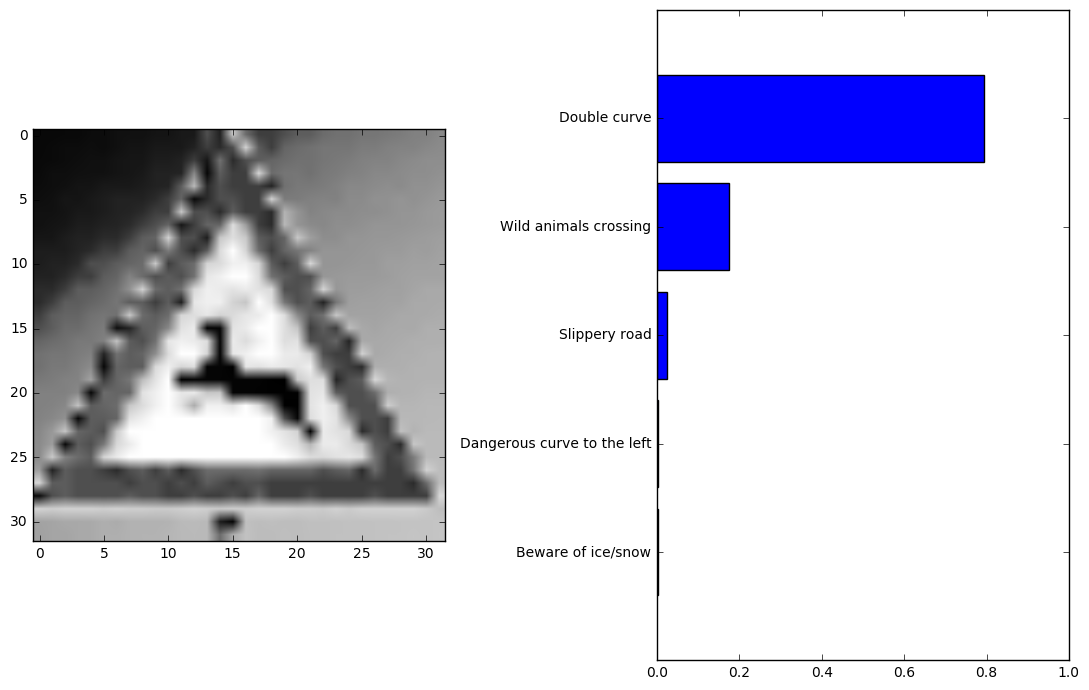

In [51]:
vizualize_soft_probabilities(signal_class, test_images[3], num_probs=5)

***Failure Analysis***
This is the failure case, we see that this label is an animal label ,
model reads it as double curve giving highest probability close to 0.8 
It gives around 0.25~0.3 for  wild animals. Which is incorrect. Need to see if any further improvements can be done. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
 As we can see, the certainty depends on the deviation to the training set. As mentioned we have 90% "easy" images and 10% "hard" images. The easy images are recognized with almost 100% certainty. The hard ones are recognized wrongly but the correct prediction still is in the top 3

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.